In [1]:
import os
import time
import cv2
import numpy as np
import torch
import torchvision
import torch.optim as optim

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from model import Net

net = Net()
net.cuda()
print(net)

Net(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(

In [3]:
import dataset

train_loader, val_loader = dataset.create_loaders(val_percent = 20, batch_size = 10)


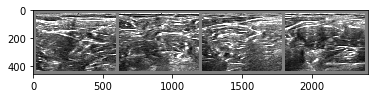

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4], nrow=4,padding=20))


In [5]:
def dice_coef(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) - intersection + 1.)

def falsepos(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_pred) - intersection

def falseneg(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_true) - intersection

def precision(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_pred) + 1.)

def recall(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_true) + 1.)

def fscore(y_true, y_pred):
    presci = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*(presci * rec)/(presci + rec)

def fscore_loss(y_true, y_pred):
    presci = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return -(1+1)*(presci * rec)/(1*presci + rec)

In [6]:
criterion = fscore_loss
optimizer = optim.Adam(net.parameters(), lr=1e-5)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
measures = {'dice_coeff':dice_coef, 
            'iou':iou, 
            'fp': falsepos, 
            'fn': falseneg, 
            'precision': precision, 
            'recall': recall, 
            'fscore': fscore }


In [7]:
import train

train.fit(net, train_loader, val_loader, criterion, optimizer, lrscheduler, measures, num_epochs = 10)

epoch 0: train-loss=-0.16645, val-loss=-0.40598, new_lr=0.00001
 dice_coeff:0.40599, iou:0.25632, fp:35084.13950, fn:67257.19340, precision:0.50161, recall:0.34612, fscore:0.40598,
epoch 1: train-loss=-0.51365, val-loss=-0.57368, new_lr=0.00001
 dice_coeff:0.57369, iou:0.40461, fp:28713.18181, fn:31935.79102, precision:0.58885, recall:0.56659, fscore:0.57368,
epoch 2: train-loss=-0.61155, val-loss=-0.59211, new_lr=0.00001
 dice_coeff:0.59213, iou:0.42386, fp:34840.11794, fn:12572.90756, precision:0.50101, recall:0.73788, fscore:0.59211,
epoch 3: train-loss=-0.64900, val-loss=-0.63582, new_lr=0.00001
 dice_coeff:0.63584, iou:0.46859, fp:21764.41136, fn:33005.82094, precision:0.68863, recall:0.59589, fscore:0.63582,
epoch 4: train-loss=-0.67409, val-loss=-0.65352, new_lr=0.00001
 dice_coeff:0.65353, iou:0.48766, fp:20696.31427, fn:31148.68673, precision:0.70430, recall:0.61530, fscore:0.65352,
epoch 5: train-loss=-0.69181, val-loss=-0.65134, new_lr=0.00001
 dice_coeff:0.65135, iou:0.4852

In [8]:
model_name = './ultrasound_%s.pth' % time.strftime('%m%d%H%M')
torch.save(net.state_dict(), model_name)

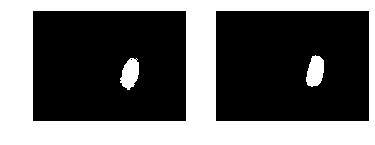

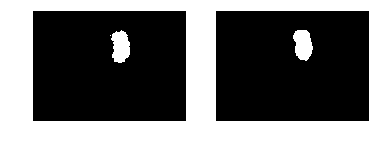

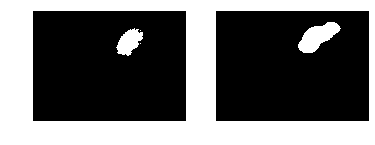

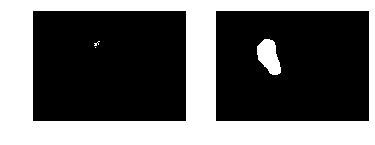

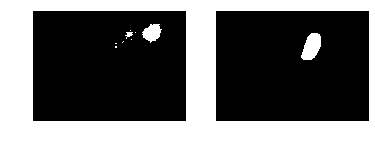

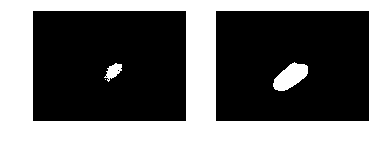

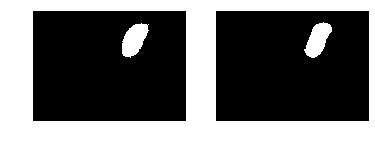

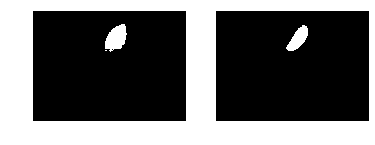

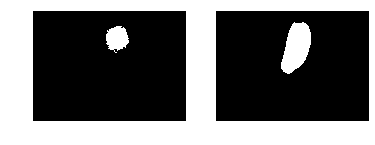

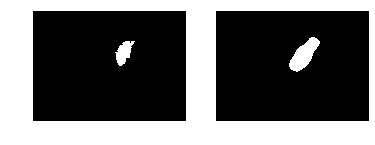

In [11]:
IMAGE_HT = 416
IMAGE_WD = 576

dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.cuda()
output = net(images)

for idx in range(10):
    x, y, label = images[idx], output[idx], labels[idx]
    
    pred = y.reshape(IMAGE_HT, IMAGE_WD)
    pred = pred.cpu()
    pred = pred.detach().numpy()
    y=np.zeros(pred.shape, dtype=np.uint8)
    y[pred == 1] = 255
    
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(y, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(label.reshape(IMAGE_HT, IMAGE_WD), cmap='gray')
